In [ ]:
!pip install wfdb

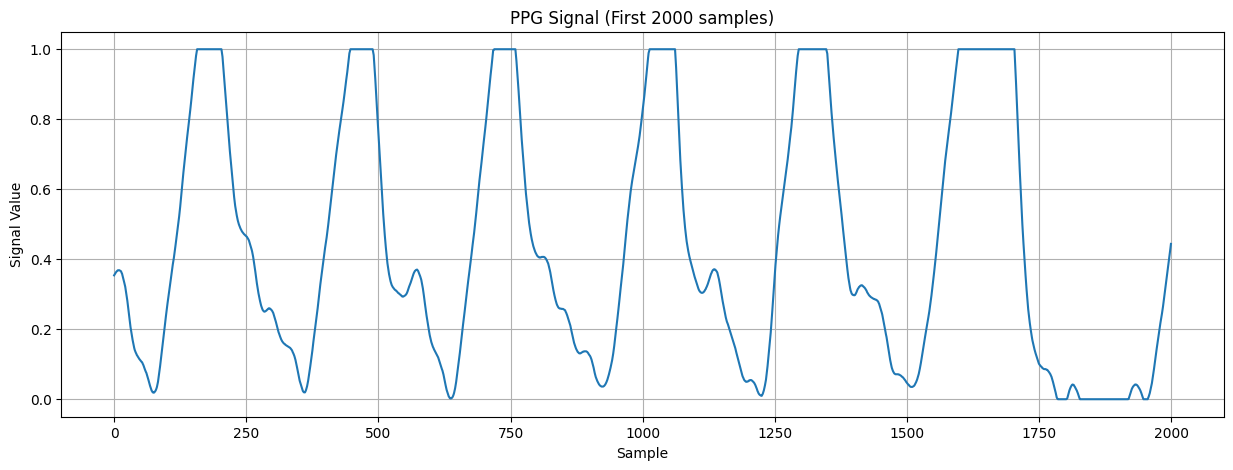

In [8]:
# 필요한 라이브러리를 불러옵니다.
import wfdb
import matplotlib.pyplot as plt

# rdsamp()는 (신호 데이터, 설명 데이터)를 반환합니다.
# 첫 번째 값인 신호 데이터를 'signals' 변수에 바로 저장합니다.
signals, fields = wfdb.rdsamp('bidmc01')

# signals 변수에 이미 데이터가 있으니, 그래프를 바로 그립니다.
# 데이터가 너무 많으니 앞부분 2000개만 잘라서 확인해봅시다.
plt.figure(figsize=(15, 5))
plt.plot(signals[:2000, 0])
plt.title("PPG Signal (First 2000 samples)")
plt.xlabel("Sample")
plt.ylabel("Signal Value")
plt.grid(True)
plt.show()

In [9]:
!pip install scipy

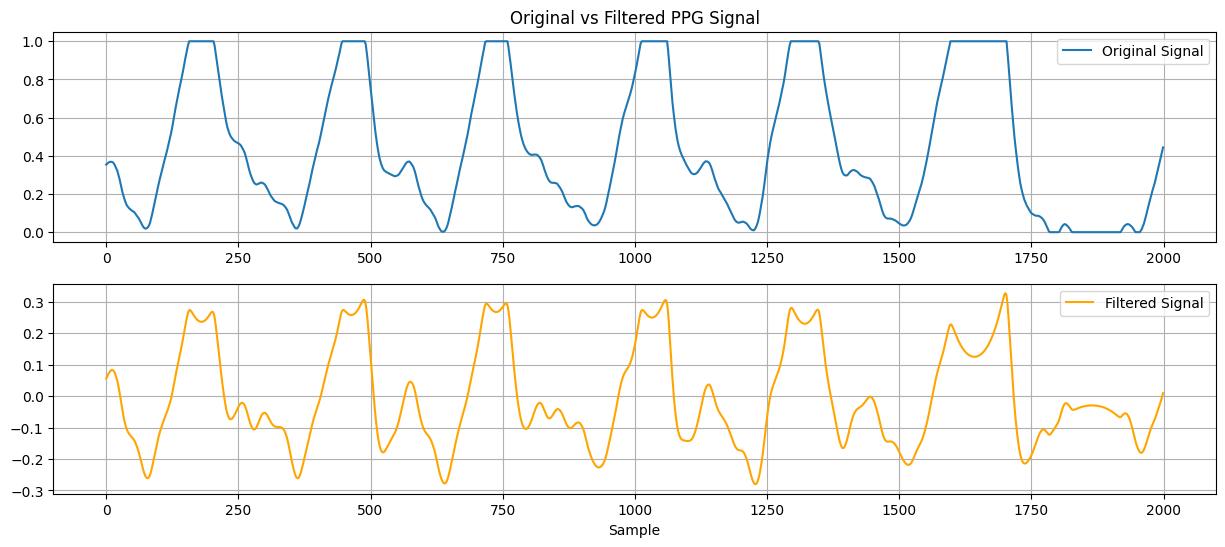

In [10]:
# 2주차에 필요한 라이브러리들을 불러옵니다.
from scipy.signal import butter, filtfilt, find_peaks
import numpy as np

# --- 1. 신호 필터링 ---
# 우리가 받은 데이터는 1초에 125번 측정되었습니다. (fs=125)
fs = 125 

# 심박수와 관련된 주파수 대역(0.5Hz ~ 8Hz)만 남기는 필터를 설계합니다.
# 0.5Hz보다 느린 신호(몸의 움직임)와 8Hz보다 빠른 신호(전기적 잡음)는 걸러냅니다.
nyquist = 0.5 * fs
low = 0.5 / nyquist
high = 8.0 / nyquist
b, a = butter(1, [low, high], btype='band')

# 'signals' 변수에 담겨있던 원본 PPG 신호에 필터를 적용합니다.
filtered_signals = filtfilt(b, a, signals[:, 0])


# --- 필터링 결과 확인 ---
# 원본 신호와 필터링된 신호를 비교해서 그려봅니다.
plt.figure(figsize=(15, 6))

plt.subplot(2, 1, 1)
plt.plot(signals[:2000, 0], label='Original Signal')
plt.title("Original vs Filtered PPG Signal")
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(filtered_signals[:2000], label='Filtered Signal', color='orange')
plt.xlabel("Sample")
plt.legend()
plt.grid(True)

plt.show()

필터링된 신호의 최대값: 0.36141633161531767


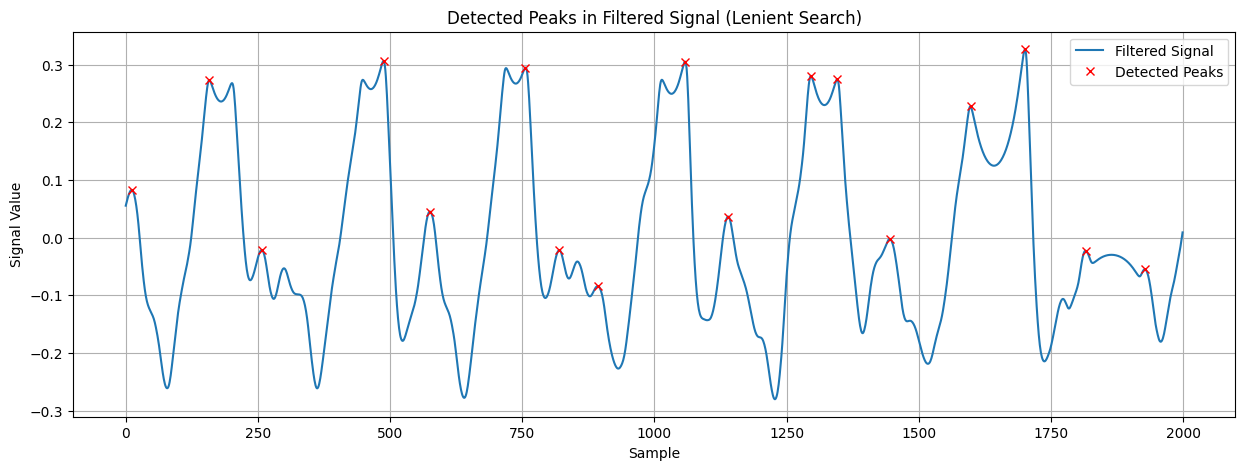

총 679개의 피크를 찾았습니다.


In [12]:
# --- 2. 신호에서 피크(Peak) 찾기 (수정된 버전) ---

# 먼저 필터링된 신호의 최대값이 얼마인지 확인해봅시다.
# 이 값을 보면 어느 정도 높이를 기준으로 잡아야 할지 감을 잡을 수 있습니다.
print(f"필터링된 신호의 최대값: {np.max(filtered_signals)}")


# height(높이) 조건을 잠시 제거해서 더 너그럽게 피크를 찾아봅니다.
peaks, _ = find_peaks(filtered_signals, distance=50)


# --- 피크 찾기 결과 확인 ---
# 필터링된 신호 위에 우리가 찾은 피크들을 빨간 점(x)으로 표시해서 확인해봅니다.
plt.figure(figsize=(15, 5))
plt.plot(filtered_signals[:2000], label='Filtered Signal')
plt.plot(peaks[peaks < 2000], filtered_signals[peaks[peaks < 2000]], "x", color='red', label='Detected Peaks')
plt.title("Detected Peaks in Filtered Signal (Lenient Search)")
plt.xlabel("Sample")
plt.ylabel("Signal Value")
plt.legend()
plt.grid(True)
plt.show()

# 찾은 피크의 개수도 출력해봅니다.
print(f"총 {len(peaks)}개의 피크를 찾았습니다.")

In [13]:
!pip install pandas

In [14]:
import pandas as pd

# --- 3. 심박변이도(HRV) 계산 ---

# 3-1. 피크와 피크 사이의 간격(RR-Interval) 계산
# 피크는 'Sample' 위치이므로, 이 위치들의 차이를 구합니다.
rr_intervals = np.diff(peaks)

# 3-2. HRV의 핵심 지표 'SDNN' 계산
# SDNN: RR-Interval들의 표준편차. 이 값이 클수록 심박이 불규칙(건강)하다는 의미.
sdnn = np.std(rr_intervals)

print(f"계산된 RR Interval의 평균: {np.mean(rr_intervals):.2f} samples")
print(f"계산된 SDNN (심박변이도): {sdnn:.2f} samples")


# --- 4. 특징(Feature) 데이터프레임 만들기 ---
# 나중에 모델을 학습시키기 위해, 계산한 특징들을 표(DataFrame)로 정리합니다.
# 지금은 전체 데이터에 대해 딱 한 개의 값만 계산했지만,
# 나중에는 데이터를 1분 단위로 잘라서 각 구간마다 HRV를 계산하게 됩니다.
hrv_features = pd.DataFrame({
    'sdnn': [sdnn],
    'mean_rr': [np.mean(rr_intervals)]
})

# --- 5. '피로' 상태 정의 (라벨링) ---
# 간단한 규칙을 정해 '피로' 상태를 정의합니다.
# 예: SDNN이 20보다 낮으면 피로(1), 아니면 정상(0)이라고 하자.
hrv_features['fatigue_label'] = hrv_features['sdnn'].apply(lambda x: 1 if x < 20 else 0)


# 최종적으로 만들어진 특징 테이블을 확인합니다.
print("\n--- 최종 특징 테이블 ---")
display(hrv_features)

계산된 RR Interval의 평균: 88.46 samples
계산된 SDNN (심박변이도): 28.02 samples

--- 최종 특징 테이블 ---


,sdnn,mean_rr,fatigue_label
0,28.015447,88.464602,0
